In [1]:
import pandas as pd

from utils import get_data, get_temperature_data
from preprocessing import select_df_columns, df_interpolate_and_dropna
from models import train_test_split, build_LSTM_model, get_Xy_generator, evaluate_model, get_model_predictions

from sklearn.preprocessing import StandardScaler
ssc = StandardScaler()

from warnings import filterwarnings
filterwarnings("ignore")

from datetime import datetime

In [2]:
%%time
df , df_raw = get_data('./data')
df_temp = get_temperature_data("./data/temperature_brescia.json")
df = df_temp.merge(df, how='outer', left_index=True, right_index=True)

Wall time: 30.2 s


In [3]:
%%time
df_prep = df.pipe(select_df_columns, ["ET_rete (potenza_termica_oraria)"])\
    .pipe(df_interpolate_and_dropna)

Wall time: 19 ms


In [4]:
window = 24*7

In [5]:
%%time
train, test = train_test_split(df_prep, 2019)

train = ssc.fit_transform(train)
test = ssc.transform(test)

X_train, y_train = get_Xy_generator(train, lenght=window)
X_test, y_test = get_Xy_generator(test, lenght=window)

model = build_LSTM_model(input_shape = window)
model.fit(X_train, y_train, epochs=5, batch_size=256, validation_split=0.2)

y_pred = model.predict(X_test)

Epoch 1/5
164/164 [==============================] - 75s 447ms/step - loss: 0.1839 - val_loss: 0.0291
Epoch 2/5
164/164 [==============================] - 72s 442ms/step - loss: 0.0265 - val_loss: 0.0225
Epoch 3/5
164/164 [==============================] - 74s 451ms/step - loss: 0.0223 - val_loss: 0.0174
Epoch 4/5
164/164 [==============================] - 72s 441ms/step - loss: 0.0163 - val_loss: 0.0143
Epoch 5/5
164/164 [==============================] - 71s 430ms/step - loss: 0.0140 - val_loss: 0.0151
Wall time: 6min 19s


In [6]:
y_test = ssc.inverse_transform(y_test.reshape(-1,1))
y_pred = ssc.inverse_transform(y_pred.reshape(-1,1))

In [7]:
%%time
evaluate_model(y_test, y_pred)

mse = 82.11395390056879
mape = 9.569713850469098
r2_score = 0.9876969428265215
Wall time: 2 ms


In [8]:
model.evaluate(X_test, ssc.transform(y_test.reshape(-1,1)))

524/524 [==============================] - 15s 27ms/step - loss: 0.0058


0.005774170625954866

In [9]:
now = datetime.utcnow().strftime("%Y%m%d%H%M")
model.save(f'models/{now}_LSTM_7.h5')

In [10]:
y_pred

array([[81.99398 ],
       [83.25031 ],
       [84.661514],
       ...,
       [48.685703],
       [48.685703],
       [48.685703]], dtype=float32)

In [11]:
y_test

array([[77.70629384],
       [79.099183  ],
       [80.49207216],
       ...,
       [43.71148685],
       [43.71148685],
       [43.71148685]])

#############################################################################################################

In [12]:
import numpy as np

In [15]:
train.shape, test.shape

((52584, 1), (16920, 1))

In [16]:
len(test)

16920

In [ ]:
train[-window:].reshape((1, window, 1))

In [ ]:
np.append(arr=train[-24:].reshape((1, window, 1))[:, 1:, :], values=[[[model.predict(train[-window:].reshape((1, window, 1)))[0][0]]]], axis=1)

In [ ]:
model.predict(train[-window:].reshape((1, window, 1)))[0][0]

In [17]:
%%time
l2hat = get_model_predictions(train, test, model, window=window)

Wall time: 11min 55s


In [ ]:
# l2hat_hat = []
# for i in l2hat:
#     l2hat_hat.append(i[0])

In [18]:
l2hat_hat = ssc.inverse_transform(l2hat)

In [19]:
ssc.inverse_transform(test)[:10]

array([[212.8346221 ],
       [214.36125175],
       [212.2325999 ],
       [209.98164047],
       [234.84462518],
       [286.89011753],
       [400.83020762],
       [392.74915553],
       [378.00535153],
       [353.10357092]])

In [20]:
df_test = df[["ET_rete (potenza_termica_oraria)"]].loc["2020":].interpolate()

In [21]:
df_test["predictions"] = l2hat_hat

In [22]:
evaluate_model(df_test["ET_rete (potenza_termica_oraria)"], df_test["predictions"])

mse = 79054.11461735195
mape = 499.30121187046853
r2_score = -10.647934138522473


In [23]:
evaluate_model(ssc.inverse_transform(test), l2hat_hat)

mse = 79054.11461735195
mape = 499.20637395881545
r2_score = -10.647934138522473


In [24]:
evaluate_model(test, l2hat)

mse = 5.558955169449761
mape = 821.474124603815
r2_score = -10.647933555386459


In [25]:
df_test.head(48)

,ET_rete (potenza_termica_oraria),predictions
2020-01-01 00:00:00,212.834622,202.920792
2020-01-01 01:00:00,214.361252,197.549240
2020-01-01 02:00:00,212.232600,202.947952
2020-01-01 03:00:00,209.981640,212.096725
2020-01-01 04:00:00,234.844625,235.219666
2020-01-01 05:00:00,286.890118,299.240875
2020-01-01 06:00:00,400.830208,407.158173
2020-01-01 07:00:00,392.749156,444.916534
2020-01-01 08:00:00,378.005352,424.602448
2020-01-01 09:00:00,353.103571,397.325989


In [31]:
evaluate_model(df_test.head(12)["ET_rete (potenza_termica_oraria)"], df_test.head(12)["predictions"])

mse = 801.6883508634745
mape = 6.764435134869373
r2_score = 0.8530148968720643


In [32]:
evaluate_model(df_test.head(48)["ET_rete (potenza_termica_oraria)"], df_test.head(48)["predictions"])

mse = 6595.15074431447
mape = 26.41279901804237
r2_score = -0.5757104477545172


<AxesSubplot:>

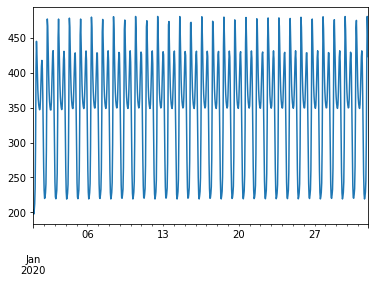

In [27]:
df_test["predictions"].loc[:"2020-01"].plot()

In [35]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from models import mean_absolute_percentage_error

In [33]:
def get_forecast_measures(y_true, y_pred):
    '''
    Params:
    -------
    y_true: numpy.array
    y_pred: numpy.array
    
    Returns:
    --------
    d: dict
    
    '''
    d = {}
    for i in range(1, len(y_true)+1):
        d[i] = {"mae" : mean_absolute_error(y_true[:i], y_pred[:i]),
                "mape" : mean_absolute_percentage_error(y_true[:i], y_pred[:i])}
    return d

In [36]:
d = get_forecast_measures(df_test.values[:,0], df_test.values[:,1])

<AxesSubplot:>

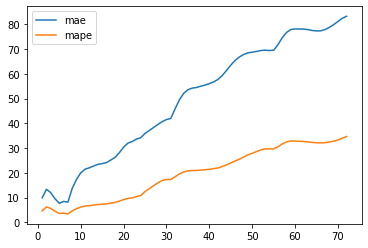

In [38]:
pd.DataFrame().from_dict(d, orient = 'index').head(72).plot()